# Analyse public tags added to Trove

This notebook loads public tags that users have added to records in Trove from the CSV file [harvested by this notebook](harvest-tags.ipynb). It then attempts some analysis of the tags.

The complete CSV is too large to store on GitHub. You can download it from [CloudStor](https://cloudstor.aarnet.edu.au/plus/s/YiWStNrhnTo18JI) or [Zenodo](https://doi.org/10.5281/zenodo.5094314).

User content added to Trove, including tags, is available for reuse under a CC-BY-NC licence.

In [25]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
import altair as alt
import pandas as pd
from wordcloud import WordCloud

In [26]:
# You will need to download the CSV file first from CloudStor or Zenodo
df = pd.read_csv("trove_tags_20220706.csv")

## Tags by zone

In [27]:
df["zone"].value_counts()

newspaper     8578901
book           573677
picture         98764
gazette         84769
music           52560
article         22695
map              7011
list             6681
collection       3879
Name: zone, dtype: int64

## How many duplicates across zones?

A single resource in Trove can appear in multiple zones – for example, a book that includes maps and illustrations might appear in the 'book', 'picture', and 'map' zones. This means that some of the tags will essentially be duplicates – harvested from different zones, but relating to the same resource. We can quantify this by finding put how many tags there are in the overlapping 'book', 'article', 'picture', 'music', 'map', and 'collection' zones, then dropping duplicates based on the `tag`, `date` and `record_id` fields.

In [28]:
# Total tags across overlapping zones
df.loc[
    df["zone"].isin(["book", "article", "picture", "music", "map", "collection"])
].shape

(758586, 4)

Now let's remove the duplicates and see how many are left.

In [29]:
df.loc[
    df["zone"].isin(["book", "article", "picture", "music", "map", "collection"])
].drop_duplicates(subset=["tag", "date", "record_id"]).shape

(700263, 4)

So there's about 50,000 'duplicates'. This doesn't really matter if you want to examine tagging behaviour within zones, but if you're aggregating tags across zones you might want to remove them, as demonstrated below.

## Top tags!

If we're going to look at the most common tags across all zones, then we should probably remove the duplicates mentioned above first.

In [30]:
# Dedupe overlapping zones
deduped_works = df.loc[
    df["zone"].isin(["book", "article", "picture", "music", "map", "collection"])
].drop_duplicates(subset=["tag", "date", "record_id"])

# Non overlapping zones
other_zones = df.loc[df["zone"].isin(["newspaper", "gazette", "list"])]

# Combine the two to create a new deduped df
deduped = pd.concat([deduped_works, other_zones])

In [31]:
deduped.shape

(9370614, 4)

Now let's view the 50 most common tags.

In [32]:
deduped["tag"].value_counts()[:50]

north shore                    44542
lrrsa                          34381
tccc                           28550
north sydney council           23649
poem                           22282
australian colonial music      21778
l1                             21658
gag cartoon                    19758
melbourne football club        17906
crossword puzzle               17618
political cartoon              16110
crossword puzzle solution      15819
tbd                            15660
fiction                        15542
slvfix                         14806
rowing & sculling              13200
corrected in full              12584
illustration type cartoon      12216
cammeray golf club             12193
serials                        11217
australian laureates           11128
captain e t miles              10373
advertising                    10061
cricket                         9840
t a reynolds                    9512
city police court               9288
second edition                  9131
h

Let's convert the complete tag counts into a new dataframe, and save it as a CSV file.

In [33]:
tag_counts = deduped["tag"].value_counts().to_frame().reset_index()
tag_counts.columns = ["tag", "count"]

In [34]:
tag_counts.to_csv("trove_tag_counts_20220706.csv", index=False)

Let's display the top 200 tags as a word cloud.

In [35]:
# Get the top 200 tags
top_200 = tag_counts[:200].to_dict(orient="records")

In [36]:
# Reshape into a tag:count dictionary.
top_200 = {tag["tag"]: tag["count"] for tag in top_200}

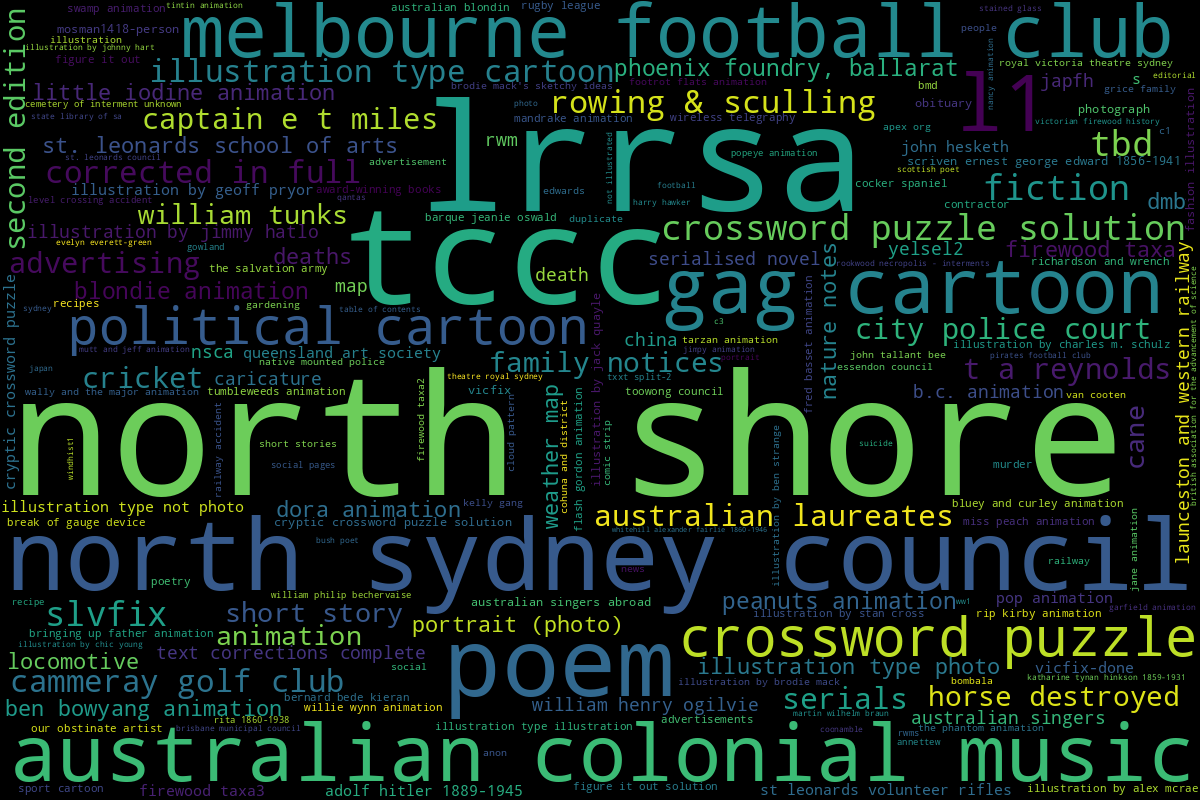

In [37]:
WordCloud(width=1200, height=800).fit_words(top_200).to_image()

## Tags on pictures

Most of the tags are on newspaper articles, but we can filter the results to look at the top tags in other zones.

In [38]:
df.loc[df["zone"] == "picture"]["tag"].value_counts()[:20]

c1                           3260
c3                           2388
sun pic                      1946
hillgrove ww1                1277
morgan harry                 1277
politicians                  1099
photos                        968
aviators and aviation         846
1931                          818
1932                          731
daily telegraph pic           688
1930                          677
1928                          670
ship passengers               631
australian colonial music     607
sydney harbour bridge         601
nsw mlas                      562
1927                          531
1925                          492
sydney harbour                490
Name: tag, dtype: int64

## View tags by year

We can use the `date` field to examine when tags were added.

In [39]:
# Convert date to datetime data type
df["date"] = pd.to_datetime(df["date"])

In [40]:
# Create a new column with the year
df["year"] = df["date"].dt.year

In [41]:
# Get counts of tags by year
year_counts = df.value_counts(["year", "zone"]).to_frame().reset_index()
year_counts.columns = ["year", "zone", "count"]

In [42]:
# Chart tags by year
alt.Chart(year_counts).mark_bar(size=18).encode(
    x=alt.X("year:Q", axis=alt.Axis(format="c")),
    y=alt.Y("count:Q", stack=True),
    color="zone:N",
    tooltip=["year:Q", "count:Q", "zone:N"],
)

alt.Chart(...)

An obvious feature in the chart above is the large number of tags in zones other than 'newspaper' that were added in 2009. From memory I believe these 'tags' were automatically ingested from related Wikipedia pages. Unlike the bulk of the tags, these were not added by individual users, so if your interest is user activity you might want to exclude these by filtering on date or zone.

## View tags by month

In [43]:
# This creates a column with the date of the first day of the month in which the tag was added
# We can use this to aggregate by month
df["year_month"] = (
    df["date"] + pd.offsets.MonthEnd(0) - pd.offsets.MonthBegin(normalize=True)
)

In [44]:
# Get tag counts by month
month_counts = df.value_counts(["year_month", "zone"]).to_frame().reset_index()
month_counts.columns = ["year_month", "zone", "count"]

In [45]:
alt.Chart(month_counts).mark_bar().encode(
    x="yearmonth(year_month):T",
    y="count:Q",
    color="zone:N",
    tooltip=["yearmonth(year_month):T", "count", "zone"],
).properties(width=700).interactive()

alt.Chart(...)

So we can see that the machine generated tags were added in November 2009. We can even zoom in further to see on which days most of the automatically generated tags were ingested.

In [46]:
df.loc[df["year_month"] == "2009-11-01"]["date"].dt.floor("d").value_counts()

2009-11-01 00:00:00+00:00    522240
2009-11-02 00:00:00+00:00     67663
2009-11-28 00:00:00+00:00      1693
2009-11-13 00:00:00+00:00      1643
2009-11-06 00:00:00+00:00      1107
2009-11-08 00:00:00+00:00      1009
2009-11-29 00:00:00+00:00       939
2009-11-16 00:00:00+00:00       891
2009-11-24 00:00:00+00:00       871
2009-11-20 00:00:00+00:00       869
2009-11-03 00:00:00+00:00       867
2009-11-10 00:00:00+00:00       858
2009-11-15 00:00:00+00:00       846
2009-11-21 00:00:00+00:00       837
2009-11-18 00:00:00+00:00       832
2009-11-22 00:00:00+00:00       812
2009-11-14 00:00:00+00:00       786
2009-11-26 00:00:00+00:00       779
2009-11-19 00:00:00+00:00       740
2009-11-05 00:00:00+00:00       704
2009-11-07 00:00:00+00:00       696
2009-11-27 00:00:00+00:00       695
2009-11-17 00:00:00+00:00       666
2009-11-09 00:00:00+00:00       585
2009-11-25 00:00:00+00:00       582
2009-11-11 00:00:00+00:00       553
2009-11-12 00:00:00+00:00       512
2009-11-23 00:00:00+00:00   

## View tags by month in newspapers and gazettes

In [47]:
alt.Chart(
    month_counts.loc[month_counts["zone"].isin(["newspaper", "gazette"])]
).mark_bar().encode(
    x="yearmonth(year_month):T",
    y="count:Q",
    color="zone:N",
    tooltip=["yearmonth(year_month):T", "count", "zone"],
).properties(
    width=700
)

alt.Chart(...)

What's the trend in newspaper tagging? There seems to have been a drop since the Trove interface was changed, but the month-to-month differences are quite large, so there might be other factors at play.

In [48]:
base = (
    alt.Chart(
        month_counts.loc[
            (month_counts["zone"].isin(["newspaper"]))
            & (month_counts["year_month"] < "2022-07-01")
        ]
    )
    .mark_point()
    .encode(
        x="yearmonth(year_month):T",
        y="count:Q",
        tooltip=["yearmonth(year_month):T", "count", "zone"],
    )
    .properties(width=700)
)

polynomial_fit = base.transform_regression(
    "year_month", "count", method="poly", order=4
).mark_line(color="red")


alt.layer(base, polynomial_fit)

alt.LayerChart(...)

----

Created by [Tim Sherratt](https://timsherratt.org/) for the [GLAM Workbench](https://glam-workbench.net/). Support this project by becoming a [GitHub sponsor](https://github.com/sponsors/wragge).